In [89]:
import tensorflow as tf 
import numpy as np 
from src import layers, utils, models
import matplotlib.pyplot as plt 
from importlib import reload 
reload(layers)
reload(models)

<module 'src.models' from '/mnt/a/Users/Claudio/Documents/PROJECTS/Infini-Attention-tf/src/models.py'>

In [124]:
B = 10
C = 50
I = 15
D = 2
H = 3
N = 4
T = C*N
x = tf.random.normal(shape=(B, C, I))

states = [tf.zeros(shape=(B, H, D, D)), tf.zeros(shape=(B, H, D))]
ac = layers.AttentionRNNCell(dims=D, heads=H, context_length=C)
rnn = tf.keras.layers.RNN(ac)
model = models.InfiniAttentionModel(dims=D, heads=H, context_length=C)
model.compile("adam", "mse")

li = tf.keras.Input(shape=(None, 2))
cells = [tf.keras.layers.LSTMCell(units=5, activation="elu") for _ in range(H-1)]
cells.append(tf.keras.layers.LSTMCell(units=2, activation="linear"))
lstm = tf.keras.layers.RNN(
    tf.keras.layers.StackedRNNCells(cells),
    return_sequences=True, return_state=False)
lo = lstm(li)
lstm_model = tf.keras.models.Model(li, lo)
lstm_model.compile("adam", "mse")

'li = tf.keras.Input(shape=(None, 2))\ncells = [tf.keras.layers.LSTMCell(units=5, activation="elu") for _ in range(H-1)]\ncells.append(tf.keras.layers.LSTMCell(units=2, activation="linear"))\nlstm = tf.keras.layers.RNN(\n    tf.keras.layers.StackedRNNCells(cells),\n    return_sequences=True, return_state=False)\nlo = lstm(li)\nlstm_model = tf.keras.models.Model(li, lo)\nlstm_model.compile("adam", "mse")'

In [59]:
xt = utils.generate_sin(length=400)
xt = tf.transpose(xt, (2, 0, 1))

x_in = []
for t in range(N):
    x_in.append(xt[:, t*C:((t+1)*C)][:, None, :, :])
x_in = tf.concat(x_in, axis=1)

In [80]:
o = model(x_in)

In [125]:
epochs = 400

history = model.fit(x_in, x_in, epochs=400, batch_size=50)
o = model(x_in)
o = o.numpy().reshape(B, -1, 2)

lstm_history = lstm_model.fit(xt, xt, epochs=400, batch_size=50)
olstm = lstm_model(xt)
olstm = olstm.numpy().reshape(B, -1, 2)

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 0.4916
Epoch 2/400
1/1 [==============================] - 0s 68ms/step - loss: 0.4913
Epoch 3/400
1/1 [==============================] - 0s 59ms/step - loss: 0.4909
Epoch 4/400
1/1 [==============================] - 0s 72ms/step - loss: 0.4906
Epoch 5/400
1/1 [==============================] - 0s 39ms/step - loss: 0.4902
Epoch 6/400
1/1 [==============================] - 0s 47ms/step - loss: 0.4899
Epoch 7/400
1/1 [==============================] - 0s 55ms/step - loss: 0.4896
Epoch 8/400
1/1 [==============================] - 0s 23ms/step - loss: 0.4892
Epoch 9/400
1/1 [==============================] - 0s 27ms/step - loss: 0.4888
Epoch 10/400
1/1 [==============================] - 0s 25ms/step - loss: 0.4885
Epoch 11/400
1/1 [==============================] - 0s 34ms/step - loss: 0.4881
Epoch 12/400
1/1 [==============================] - 0s 38ms/step - loss: 0.4878
Epoch 13/400
1/1 [==============================] -

'lstm_history = lstm_model.fit(xt, xt, epochs=400, batch_size=50)\nolstm = lstm_model(xt)\nolstm = olstm.numpy().reshape(B, -1, 2)'

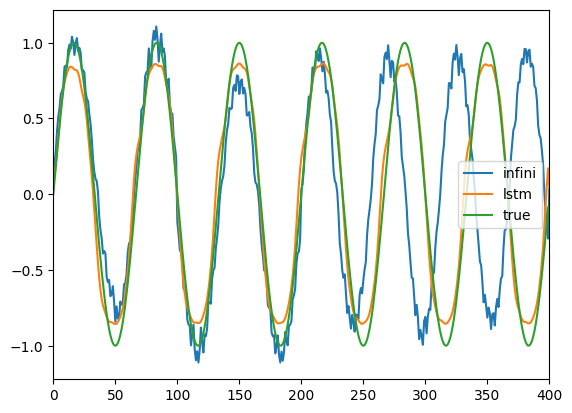

In [126]:
plt.plot(o[0, :, 0], label="infini")
plt.plot(olstm[0, :, 0], label="lstm")
plt.plot(xt[0, :, 0], label="true")
plt.xlim(0, 400)
plt.legend()

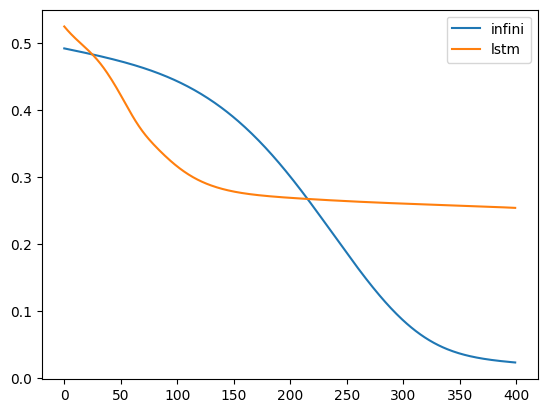

In [127]:
hi = history.history["loss"]
hl = lstm_history.history["loss"]

plt.plot(hi, label="infini")
plt.plot(hl, label="lstm")
plt.legend()